<a href="https://colab.research.google.com/github/ThousandAI/Application-of-AI/blob/main/class06/Resnet_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer Learning**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Hyper-parameters 
num_epochs = 2
batch_size = 64
learning_rate = 1e-4 #0.0001

### Cifar10

In [4]:
transform = transforms.Compose(
    [ transforms.Resize([224,224]),
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
iterator = iter(train_loader)
images,labels = next(iterator)
print(images.shape, labels.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [6]:
def show(img):
  img = img / 2 + 0.5  # unnormalize
  npimg = img.numpy()
  return np.transpose(npimg, (1, 2, 0))

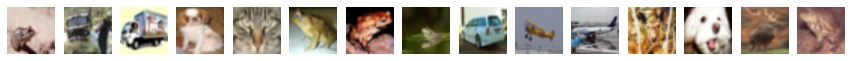

In [7]:
fig, axes = plt.subplots(1,15, figsize=(15, 15))
for i in range(15):
  axes[i].imshow(show(images[i]))
  axes[i].set_axis_off()
fig.show()

### resnet50

In [8]:
# resnet50 = torchvision.models.resnet50(pretrained=True).to(device)
resnet50 = torchvision.models.resnet50(weights="IMAGENET1K_V2")
print(resnet50)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
resnet50.fc = nn.Linear(in_features=2048, out_features=10, bias=True)

In [10]:
resnet50 = resnet50.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet50.parameters(), lr=learning_rate)

In [11]:
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(resnet50)

23528522

In [13]:
n_total_steps = len(train_loader)
for epoch in tqdm(range(num_epochs)):
  for i, (images, labels) in enumerate(train_loader):
    # origin shape: [64, 3, 224, 224]
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = resnet50(images)
    loss = criterion(outputs, labels)
    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
      print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch [1/2], Step [100/782], Loss: 0.2980
Epoch [1/2], Step [200/782], Loss: 0.2499
Epoch [1/2], Step [300/782], Loss: 0.3154
Epoch [1/2], Step [400/782], Loss: 0.1349
Epoch [1/2], Step [500/782], Loss: 0.1482
Epoch [1/2], Step [600/782], Loss: 0.3367
Epoch [1/2], Step [700/782], Loss: 0.0994


 50%|█████     | 1/2 [05:19<05:19, 319.41s/it]

Epoch [2/2], Step [100/782], Loss: 0.0247
Epoch [2/2], Step [200/782], Loss: 0.0598
Epoch [2/2], Step [300/782], Loss: 0.0845
Epoch [2/2], Step [400/782], Loss: 0.0479
Epoch [2/2], Step [500/782], Loss: 0.0625
Epoch [2/2], Step [600/782], Loss: 0.0637
Epoch [2/2], Step [700/782], Loss: 0.0918


100%|██████████| 2/2 [10:29<00:00, 314.60s/it]


In [14]:
with torch.no_grad():
  n_correct = 0
  n_samples = 0
  n_class_correct = [0 for i in range(10)]
  n_class_samples = [0 for i in range(10)]
  for images, labels in test_loader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = resnet50(images)
    # max returns (value ,index)
    _, predicted = torch.max(outputs, 1)
    n_samples += labels.size(0)
    n_correct += (predicted == labels).sum().item()

  acc = 100.0 * n_correct / n_samples
  print(f'Accuracy of the network: {acc} %')

Accuracy of the network: 95.28 %
